### 1. Using a Mixed-data clustering algorithm to identify cluster from the HINTS study and exploring classifiers to predict fatalism among people who have sought out cancer-related information

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sns
import altair as alt
import scipy as sc
#import tableone
#from tableone import TableOne

pd.options.mode.chained_assignment = None 
import warnings
warnings.filterwarnings('ignore')
#%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (12, 6) 
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', None)

### 2. Objectives and learning experience from personal point of view
1. Improve data preparation skills for machine learning projects.
2. Improve data exploration skills. 
3. Get familiar with several classification algorithms and know how and when to use which.
4. Learn how to do clustering analyses in order to identify groups of subjects from the data.

### 3. Dataset description and descriptives statistics

The dataset comes from the Health Information National Trends Survey of 2012 conducted by the National Cancer Institute. The purpose of the survey was to collect data on how Americans consume information related to cancer. 
<br> </br>
Shape and features: The data is for 3630 respondents and has 357 features. It can be accessed at https://hints.cancer.gov/data/download-data.aspx.

The main feature of inteterest for the classification experiments are: 'PreventNotPossible'? (belief that it's not possiblie to prevent cancer) and 'EverythingCauseCancer' ( belief that everything causes cancer). These were questions asked in in the HINTS survey. These variables were combined into one as 'fatalview', if a respondent responded agreeing to any of these questions regarding their beliefs. 


### 4. Literature Review 

Several papers have sought to characterize patterns of information seeking among the people from the HINTS survey. However, relatively few have focused on understanding and characterizing those individuals, especifically around those who hold fatalistic views with respect to cancer. Fatalistic views are defined as negative ideas with respect to cancer recovery and prevention.

Sinky and colleagues first exmplored fatalistism with respect to cancer in 2018. Their researched concluded that fatalistic beliefs about cancer are common, and further research is warranted to understand cancer fatalism and whether and how it may impact health. The majority of the papers published on this data have used traditional logistic regression models to understand assocations around fatalism. 

It is not very common for patients to talk with their physician about these views, so it may be hard to identify a patient that is fatalistic. These patients tend to adhere less to medications and tend to avoid medical care, potentialy being costly for health systems.Therefore I thought it would be helpful to develop models to see if these patients can be predicted using other information that may be had from the clinical record. After the literature review, there are no other groups going on this direction

Source: Sinky TH, Faith J, Lindly O, Thorburn S. Cancer Fatalism and Preferred Sources of Cancer Information: an Assessment Using 2012 HINTS Data. J Cancer Educ. 2018 Feb;33(1):231-237. doi: 10.1007/s13187-016-1115-1. PMID: 27650861.

Source: De Jesus M, Miller EB (2014) Fatalistic beliefs or structural factors impeding screening?: examining “real” barriers to breast cancer screening among Latina immigrants. Health Care for Women Int. doi:10.1080/07399332.2014.973496


### 5. Hypothesis:  

Clustering Experiment:
Clustering analyses of the data via k-prototypes would yield better clusters (more differentiable clusters) than a clustering algorith applied to categorical data (being represented as numerical). 

Classification Experiment:
The XGBoost algorithm has a better performance than RF in predicting wether a patient has fatalistic views or not. 

In [2]:
#Import data
data = pd.read_spss('hints4cycle2_07312020_public.sav')
pd.set_option('display.max_columns', None)

#Get shape
print(data.shape)
#data.head()

(3630, 357)


In [3]:
#Vars of interest
var = [ 'Age',
        'GeneralHealth',
        'IncomeRanges_IMP',      
        'EducB',
        'TypeOfAddressC',
        'RentOrOwn',
        'CellPhone',
        'smokeStat',
        'BMI',
        'TimesModerateExercise',
        'Worrying',
        'EmotionalSupport',
        'LittleInterest',
        'EverythingCauseCancer', #fatalistic views
        'PreventNotPossible', #fatalistic views
        'MedConditions_Diabetes',
        'MedConditions_HighBP',
        'MedConditions_HeartCondition',
        'MedConditions_LungDisease',
        'MedConditions_Arthritis',
        'MedConditions_Depression',
        'EverHadCancer', #cancer survivor
        'QualityCare',
        'RegularProvider',
        'HealthInsurance',
        'Deaf',
        'Blind',
        'Race_Cat2',
        'Hisp_Cat',
        'BornInUSA',
        'GenderC',
        'SpeakEnglish'] 

#removed language flag, 

### Save intermediate results

In [4]:
df = data[var]
df

,Age,GeneralHealth,IncomeRanges_IMP,EducB,TypeOfAddressC,RentOrOwn,CellPhone,smokeStat,BMI,TimesModerateExercise,Worrying,EmotionalSupport,LittleInterest,EverythingCauseCancer,PreventNotPossible,MedConditions_Diabetes,MedConditions_HighBP,MedConditions_HeartCondition,MedConditions_LungDisease,MedConditions_Arthritis,MedConditions_Depression,EverHadCancer,QualityCare,RegularProvider,HealthInsurance,Deaf,Blind,Race_Cat2,Hisp_Cat,BornInUSA,GenderC,SpeakEnglish
0,29.0,"Very good,","$75,000 to $99,999",Some College,Not Selected,Own,Yes,Current,29.0,5 days per week,Not at all,Yes,Not at all,Strongly agree,Somewhat agree,No,No,No,No,No,Yes,No (GO to question N1 (K1)),Excellent,Yes,Yes,No,No,White,Not Hispanic,Yes (Go to Question O10(L10)),Female,"Inapplicable, coded 1 in BornInUSA"
1,69.0,"Very good,","$20,000 to $34,999",High School Graduate,Not Selected,Own,Yes,Former,27.3,5 days per week,Not at all,Yes,Not at all,Somewhat agree,Somewhat disagree,No,Yes,No,No,Yes,Yes,No (GO to question N1 (K1)),Excellent,Yes,Yes,No,No,White,Not Hispanic,Yes (Go to Question O10(L10)),Female,"Inapplicable, coded 1 in BornInUSA"
2,32.0,"Very good,","$100,000 to $199,999",Bachelor's Degree,Not Selected,Own,Yes,Current,20.4,3 days per week,Several days,Yes,Not at all,Somewhat agree,Somewhat disagree,No,No,No,Yes,No,No,No (GO to question N1 (K1)),Very good,Yes,Yes,No,No,Filipino,Not Hispanic,Yes (Go to Question O10(L10)),Female,"Inapplicable, coded 1 in BornInUSA"
3,41.0,"Very good,","$200,000 or more",Post-Baccalaureate Degree,Not Selected,Own,Yes,Never,22.1,6 days per week,Not at all,Yes,Not at all,Somewhat agree,Strongly disagree,No,No,No,No,No,No,No (GO to question N1 (K1)),Very good,Yes,Yes,No,No,Black,Not Hispanic,Yes (Go to Question O10(L10)),Female,"Inapplicable, coded 1 in BornInUSA"
4,46.0,"Good,","$35,000 to $49,999",Missing Data (Not Ascertained),Not Selected,Own,Yes,Never,28.9,2 days per week,Not at all,Yes,Not at all,Somewhat agree,Somewhat agree,No,Yes,No,No,No,No,No (GO to question N1 (K1)),Good,No,No,No,No,White,Not Hispanic,Yes (Go to Question O10(L10)),Female,"Inapplicable, coded 1 in BornInUSA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,89.0,"Fair, or","$15,000 to $19,999",Less than High School,Not Selected,Rent,Yes,Never,23.9,None (Go to question H3(F7)),Several days,Yes,Several days,Strongly disagree,Strongly disagree,No,No,No,No,Yes,Yes,Yes,Very good,Yes,Yes,Yes,No,White,Not Hispanic,Yes (Go to Question O10(L10)),Male (Go to Question L1(I1)),Question answered in error (Commission Error)
3626,81.0,"Good,","$35,000 to $49,999",Post-Baccalaureate Degree,Not Selected,Own,Yes,Never,25.8,None (Go to question H3(F7)),Not at all,Yes,Not at all,Strongly disagree,Somewhat agree,Yes,Yes,No,No,Yes,No,No (GO to question N1 (K1)),Excellent,Yes,Yes,No,No,White,Not Hispanic,Yes (Go to Question O10(L10)),Male (Go to Question L1(I1)),Question answered in error (Commission Error)
3627,44.0,"Good,","$75,000 to $99,999",High School Graduate,Missing Data,Own,Yes,Current,29.0,7 days per week,Several days,No,Several days,Somewhat agree,Strongly disagree,No,Yes,No,Yes,No,Yes,No (GO to question N1 (K1)),Good,Yes,Yes,No,No,White,Not Hispanic,Yes (Go to Question O10(L10)),Female,Question answered in error (Commission Error)
3628,29.0,"Good,","$10,000 to $14,999",Some College,Not Selected,Rent,Yes,Current,23.7,1 day per week,More than half the days,Yes,Several days,Somewhat disagree,Strongly disagree,No,No,No,No,No,No,No (GO to question N1 (K1)),"Inapplicable, coded 0 in FreqGoProvider",No,No,No,No,White,Other Hispanic,No,Female,Very well


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3630 entries, 0 to 3629
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Age                           3630 non-null   category
 1   GeneralHealth                 3630 non-null   category
 2   IncomeRanges_IMP              3630 non-null   category
 3   EducB                         3630 non-null   category
 4   TypeOfAddressC                3630 non-null   category
 5   RentOrOwn                     3630 non-null   category
 6   CellPhone                     3630 non-null   category
 7   smokeStat                     3630 non-null   category
 8   BMI                           3630 non-null   category
 9   TimesModerateExercise         3630 non-null   category
 10  Worrying                      3630 non-null   category
 11  EmotionalSupport              3630 non-null   category
 12  LittleInterest                3630 non-null   ca

In [6]:
# Re-Label missing/incorrect inputs as "NaN"
df[(df == 'Missing data (Not Ascertained)')|(df == 'Multiple responses selected in error')
   |(df == 'Unreadable or Non-conforming numeric response')|(df == 'Missing Data (Filter Missing)')
   |(df=='Question Answered in Error (Commission Error)')|(df=='Inapplicable, coded 2 in EverHadCancer')
   |(df=='Inapplicable, this is a Short Form')|(df=='Missing Data')
   |(df=='Inapplicable, coded 1 in EverHadCancer, or this is a Short Form')
   |(df== 'Question answered in error (Commission Error)')
   |(df=='Inapplicable, coded 1 in EverHadCancer, or this is a Short Form')
   |(df == 'Missing Data (Not Ascertained)')|(df == 'Missing data (Not Ascertained)')
   |(df == 'Missing Data (Filter Missing), coded -9 in Smoke100')
   |(df == 'Unreadable or Nonconforming Numeric Response')
   |(df == 'Missing data (Filter Missing)')|(df == 'Inapplicable, coded 0 in FreqGoProvider ') 
   |(df == 'Inapplicable, coded 0 in FreqGoProvider')|(df == 'Missing data (Not Ascertained)')|(df == 'Multiple responses selected,in error')
   |(df == 'Unreadable or Non-conforming numeric response')
   |(df == 'Missing,Data (Filter Missing)')
   |(df=='Question Answered in Error (Commission Error)')|(df=='Inapplicable,coded 2 in EverHadCancer')
   |(df=='Inapplicable, this is a Short Form')|(df=='Missing Data')] = np.nan

In [7]:
#Locate/Count Missing Values/NaN
df.isnull().sum()
missing_count = df.isnull().sum()
val_count = df.isnull().count()
missing_percent = round(missing_count / val_count * 100, 1)
miss_df = pd.DataFrame({'n': missing_count, 'Percentage': missing_percent})
miss_df.sort_values('Percentage')

,n,Percentage
TimesModerateExercise,16,0.4
EverHadCancer,31,0.9
HealthInsurance,47,1.3
smokeStat,53,1.5
RegularProvider,57,1.6
BornInUSA,61,1.7
GenderC,68,1.9
EducB,89,2.5
GeneralHealth,107,2.9
EmotionalSupport,119,3.3


In [8]:
#from the above there is no datatype object that condradicts with the above description
allFeatures=df.columns[1:len(df.columns)]

numfeatures =df.columns[list(range(0,1))+list(range(8,9))]

catfeatures= [i for i in allFeatures if not(i in numfeatures)]

In [9]:
numfeatures

Index(['Age', 'BMI'], dtype='object')

In [10]:
catfeatures

['GeneralHealth',
 'IncomeRanges_IMP',
 'EducB',
 'TypeOfAddressC',
 'RentOrOwn',
 'CellPhone',
 'smokeStat',
 'TimesModerateExercise',
 'Worrying',
 'EmotionalSupport',
 'LittleInterest',
 'EverythingCauseCancer',
 'PreventNotPossible',
 'MedConditions_Diabetes',
 'MedConditions_HighBP',
 'MedConditions_HeartCondition',
 'MedConditions_LungDisease',
 'MedConditions_Arthritis',
 'MedConditions_Depression',
 'EverHadCancer',
 'QualityCare',
 'RegularProvider',
 'HealthInsurance',
 'Deaf',
 'Blind',
 'Race_Cat2',
 'Hisp_Cat',
 'BornInUSA',
 'GenderC',
 'SpeakEnglish']

In [11]:
#in-place command 
for c in catfeatures:
    df[c]=df[c].astype('object')

In [12]:
df['BMI'] = pd.to_numeric(df['BMI'], errors = 'coerce')       
df['Age'] = pd.to_numeric(df['Age'], errors = 'coerce')  

In [13]:
df.dtypes

Age                             float64
GeneralHealth                    object
IncomeRanges_IMP                 object
EducB                            object
TypeOfAddressC                   object
RentOrOwn                        object
CellPhone                        object
smokeStat                        object
BMI                             float64
TimesModerateExercise            object
Worrying                         object
EmotionalSupport                 object
LittleInterest                   object
EverythingCauseCancer            object
PreventNotPossible               object
MedConditions_Diabetes           object
MedConditions_HighBP             object
MedConditions_HeartCondition     object
MedConditions_LungDisease        object
MedConditions_Arthritis          object
MedConditions_Depression         object
EverHadCancer                    object
QualityCare                      object
RegularProvider                  object
HealthInsurance                  object


### Impute with Mode or Mean (cat vs cont)

In [14]:
#Impute NaN Values with Mode
#df = df.fillna(df.mode().iloc[0])
from sklearn.impute import SimpleImputer 
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

imp_mode.fit(df[catfeatures])
imp_mean.fit(df[numfeatures])

SimpleImputer()

In [15]:
df[catfeatures]=imp_mode.transform(df[catfeatures])
df[numfeatures]=imp_mean.transform(df[numfeatures])

In [16]:
# Verify missing Values/NaN have been imputed.
df.isnull().sum()

Age                             0
GeneralHealth                   0
IncomeRanges_IMP                0
EducB                           0
TypeOfAddressC                  0
RentOrOwn                       0
CellPhone                       0
smokeStat                       0
BMI                             0
TimesModerateExercise           0
Worrying                        0
EmotionalSupport                0
LittleInterest                  0
EverythingCauseCancer           0
PreventNotPossible              0
MedConditions_Diabetes          0
MedConditions_HighBP            0
MedConditions_HeartCondition    0
MedConditions_LungDisease       0
MedConditions_Arthritis         0
MedConditions_Depression        0
EverHadCancer                   0
QualityCare                     0
RegularProvider                 0
HealthInsurance                 0
Deaf                            0
Blind                           0
Race_Cat2                       0
Hisp_Cat                        0
BornInUSA     

In [17]:
#save df
df.to_csv('ImputedNaN.csv', index_label= False)

In [18]:
#check data
data = pd.read_csv('ImputedNaN.csv')
print(df['QualityCare'].unique())
print(df['GeneralHealth'].unique())

['Excellent' 'Very good' 'Good' 'Fair' 'Poor']
['Very good,' 'Good,' 'Poor?' 'Excellent,' 'Fair, or']


In [199]:
### For Catfeatures only

In [19]:
#Check level names,counts, for and types in print:
#df.dtypes
for it in catfeatures:
    print('\n', it, '\n ------')
    print(df[it].value_counts())
    print('var type:', type(df[it]))


 GeneralHealth 
 ------
Good,         1384
Very good,    1232
Fair, or       509
Excellent,     382
Poor?          123
Name: GeneralHealth, dtype: int64
var type: <class 'pandas.core.series.Series'>

 IncomeRanges_IMP 
 ------
$50,000 to $74,999      689
$20,000 to $34,999      550
$35,000 to $49,999      511
$100,000 to $199,999    482
$75,000 to $99,999      426
$0 to $9,999            360
$10,000 to $14,999      253
$15,000 to $19,999      224
$200,000 or more        135
Name: IncomeRanges_IMP, dtype: int64
var type: <class 'pandas.core.series.Series'>

 EducB 
 ------
Some College                 1146
Bachelor's Degree             845
High School Graduate          775
Post-Baccalaureate Degree     535
Less than High School         329
Name: EducB, dtype: int64
var type: <class 'pandas.core.series.Series'>

 TypeOfAddressC 
 ------
Not Selected    3312
Selected         318
Name: TypeOfAddressC, dtype: int64
var type: <class 'pandas.core.series.Series'>

 RentOrOwn 
 ------
Own     

In [20]:
### Designate Ordinal Variable's Order Magnitude

var0 = ['Poor?','Fair, or','Good,', 'Very good,','Excellent,']
var1 = ['$0 to $9,999','$10,000 to $14,999','$15,000 to $19,999','$20,000 to $34,999',
        '$35,000 to $49,999','$50,000 to $74,999','$75,000 to $99,999','$100,000 to $199,999',
        '$200,000 or more']

var3 = ['Less than High School','High School Graduate',
        'Some College',"Bachelor's Degree",
        'Post-Baccalaureate Degree']

var7 = ['Occupied without paying monetary rent', 'Rent', 'Own']
var9 = ['Never','Former','Current']

var16 = ['None (Go to question H3(F7))','1 day per week','2 days per week','3 days per week',
         '4 days per week','5 days per week', '6 days per week','7 days per week']

var17 =['Not at all','More than half the days','Several days','Nearly every day']
var23 = var24 = ['Strongly disagree','Somewhat disagree','Somewhat agree','Strongly agree']
var35 = ['Poor','Fair','Good','Very good','Excellent']

In [21]:
### Create a dictionary of ordinal variables and their associated attributes. 
attributes = ['GeneralHealth','IncomeRanges_IMP','EducB',
              'RentOrOwn','smokeStat','TimesModerateExercise','Worrying','EverythingCauseCancer',
              'PreventNotPossible','QualityCare']

lists = [var0, var1,var3,var7,var9,var16,var17,var23,var24,var35]

def encode(attribute,lists):
    dictOfWords = {lists[i] : i for i in range(0,len(lists))}
    return print("data['" + str(attribute) + "'] = data['" + str(attribute) + "'].map(" + str(dictOfWords)+ ')')

In [22]:
### Map Ordinal and Binary Variables 

data['GeneralHealth'] = data['GeneralHealth'].map({'Poor?': 0, 'Fair, or': 1, 'Good,': 2, 'Very good,': 3, 'Excellent,': 4})
data['IncomeRanges_IMP'] = data['IncomeRanges_IMP'].map({'$0 to $9,999': 0, '$10,000 to $14,999': 1, '$15,000 to $19,999': 2, '$20,000 to $34,999': 3, '$35,000 to $49,999': 4, '$50,000 to $74,999': 5, '$75,000 to $99,999': 6, '$100,000 to $199,999': 7, '$200,000 or more': 8})
data['EducB'] = data['EducB'].map({'Less than High School': 0, 'High School Graduate': 1, 'Some College': 2, "Bachelor's Degree": 3, 'Post-Baccalaureate Degree': 4})
data['RentOrOwn'] = data['RentOrOwn'].map({'Occupied without paying monetary rent': 0, 'Rent': 1, 'Own': 2})
data['smokeStat'] = data['smokeStat'].map({'Never': 0, 'Former': 1, 'Current': 2})
data['TimesModerateExercise'] = data['TimesModerateExercise'].map({'None (Go to question H3(F7))': 0, '1 day per week': 1, '2 days per week': 2, '3 days per week': 3, '4 days per week': 4, '5 days per week': 5, '6 days per week': 6, '7 days per week': 7})
data['Worrying'] = data['Worrying'].map({'Not at all': 0, 'More than half the days': 1, 'Several days': 2, 'Nearly every day': 3})
data['LittleInterest'] = data['LittleInterest'].map({'Not at all': 0, 'More than half the days': 1, 'Several days': 2, 'Nearly every day': 3})
data['EverythingCauseCancer'] = data['EverythingCauseCancer'].map({'Strongly disagree': 0, 'Somewhat disagree': 1, 'Somewhat agree': 2, 'Strongly agree': 3})
data['PreventNotPossible'] = data['PreventNotPossible'].map({'Strongly disagree': 0, 'Somewhat disagree': 1, 'Somewhat agree': 2, 'Strongly agree': 3})
data['QualityCare'] = data['QualityCare'].map({'Poor': 0, 'Fair': 1, 'Good': 2, 'Very good': 3, 'Excellent': 4}) #there were commas in Very good and Excellent
data['GenderC'] = data['GenderC'].map({'Male (Go to Question L1(I1))': 1, 'Female': 0})

In [23]:
### Creating Dummy Variables
DummyVar = pd.get_dummies(df[['TypeOfAddressC',
                                'CellPhone','MedConditions_Diabetes',
                                'MedConditions_HighBP',
                                'MedConditions_HeartCondition',
                                'MedConditions_LungDisease',
                                'MedConditions_Arthritis',
                                'MedConditions_Depression',
                                'EverHadCancer','EmotionalSupport',
                                'RegularProvider','HealthInsurance',
                                'Deaf','Blind','Race_Cat2', 'Hisp_Cat','BornInUSA', 'GenderC']], drop_first = True)

#Concatenate DF
df = pd.concat([data,DummyVar],axis=1).drop(['TypeOfAddressC',
                                             'CellPhone','MedConditions_Diabetes',
                                             'MedConditions_HighBP',
                                             'MedConditions_HeartCondition',
                                             'MedConditions_LungDisease',
                                             'MedConditions_Arthritis',
                                             'MedConditions_Depression',
                                             'EverHadCancer','EmotionalSupport',
                                             'RegularProvider','HealthInsurance',
                                             'Deaf','Blind','Race_Cat2', 'Hisp_Cat','BornInUSA',
                                             'GenderC',
                                              ],axis=1)

df

,Age,GeneralHealth,IncomeRanges_IMP,EducB,RentOrOwn,smokeStat,BMI,TimesModerateExercise,Worrying,LittleInterest,EverythingCauseCancer,PreventNotPossible,QualityCare,SpeakEnglish,TypeOfAddressC_Selected,CellPhone_Yes,MedConditions_Diabetes_Yes,MedConditions_HighBP_Yes,MedConditions_HeartCondition_Yes,MedConditions_LungDisease_Yes,MedConditions_Arthritis_Yes,MedConditions_Depression_Yes,EverHadCancer_Yes,EmotionalSupport_Yes,RegularProvider_Yes,HealthInsurance_Yes,Deaf_Yes,Blind_Yes,Race_Cat2_Asian Indian,Race_Cat2_Black,Race_Cat2_Chinese,Race_Cat2_Filipino,Race_Cat2_Japanese,Race_Cat2_Korean,Race_Cat2_Multiple races selected,Race_Cat2_Other Asian,Race_Cat2_Other Pacific Islander,Race_Cat2_Samoan,Race_Cat2_Vietnamese,Race_Cat2_White,Hisp_Cat_Mexican,Hisp_Cat_Multiple Hispanic ethnicities selected,Hisp_Cat_Not Hispanic,Hisp_Cat_Other Hispanic,Hisp_Cat_Puerto Rican,BornInUSA_Yes (Go to Question O10(L10)),GenderC_Male (Go to Question L1(I1))
0,29.0,3,6,2,2,2,29.0,5,0,0,3,2,4,"Inapplicable, coded 1 in BornInUSA",0,1,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
1,69.0,3,3,1,2,1,27.3,5,0,0,2,1,4,"Inapplicable, coded 1 in BornInUSA",0,1,0,1,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
2,32.0,3,7,3,2,2,20.4,3,2,0,2,1,3,"Inapplicable, coded 1 in BornInUSA",0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,41.0,3,8,4,2,0,22.1,6,0,0,2,0,3,"Inapplicable, coded 1 in BornInUSA",0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,46.0,2,4,2,2,0,28.9,2,0,0,2,2,2,"Inapplicable, coded 1 in BornInUSA",0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,89.0,1,2,0,1,0,23.9,0,2,2,0,0,3,"Inapplicable, coded 1 in BornInUSA",0,1,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1
3626,81.0,2,4,4,2,0,25.8,0,0,0,0,2,4,"Inapplicable, coded 1 in BornInUSA",0,1,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1
3627,44.0,2,6,1,2,2,29.0,7,2,2,2,0,2,"Inapplicable, coded 1 in BornInUSA",0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
3628,29.0,2,1,2,1,2,23.7,1,1,2,1,0,3,Very well,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [205]:
### Rename Columns

In [24]:
old_names = [ 'TypeOfAddressC_Selected', 
             'CellPhone_Yes','MedConditions_Diabetes_Yes', 'MedConditions_HighBP_Yes',
             'MedConditions_HeartCondition_Yes', 'MedConditions_LungDisease_Yes',
             'MedConditions_Arthritis_Yes', 'MedConditions_Depression_Yes',
             'EverHadCancer_Yes','EmotionalSupport_Yes',
             'RegularProvider_Yes','HealthInsurance_Yes','DecisionMaking_Yes','DifficultyWalking_Yes',
             'DifficultyDressing_Yes','DifficultyErrands_Yes','Deaf_Yes','Blind_Yes',
             'Race_Cat2_Asian Indian', 'Race_Cat2_Black', 'Race_Cat2_Chinese',
             'Race_Cat2_Filipino', 'Race_Cat2_Japanese', 'Race_Cat2_Korean',
             'Race_Cat2_Multiple races selected', 'Race_Cat2_Other Asian',
             'Race_Cat2_Other Pacific Islander', 'Race_Cat2_Samoan',
             'Race_Cat2_Vietnamese', 'Race_Cat2_White', 'Hisp_Cat_Mexican',
             'Hisp_Cat_Multiple Hispanic ethnicities selected',
             'Hisp_Cat_Not Hispanic', 'Hisp_Cat_Other Hispanic',
             'Hisp_Cat_Puerto Rican','BornInUSA_Yes (Go to Question O10(L10))',
             'GenderC_Male (Go to Question L1(I1))', 'Language_Flag_Spanish']

new_names = ['TypeOfAddressC',
             'CellPhone', 'Diabetes','HighBP',
             'HeartCondition','LungDisease',
             'Arthritis','Depression','Cancer','EmotionalSupport',
             'RegularProvider','HealthInsurance',
             'DecisionMaking','DiffWalking',
             'DiffDressing','DiffErrands',
             'Deaf','Blind','Asian Indian', 'Black', 'Chinese',
             'Filipino', 'Japanese', 'Korean',
             'MultipleRaces', 'OtherAsian',
             'OtherPacificIslander', 'Samoan',
             'Vietnamese', 'White', 'Mexican',
             'MultipleHispanic',
             'Not Hispanic', 'OtherHispanic',
             'Puerto Rican','BornInUsa', 'Gender', 'Survey_Spanish']

name_dict = dict(zip(old_names,new_names))
df = df.rename(columns = name_dict)

In [25]:
df['EverythingCauseCancer'].value_counts()        
df['PreventNotPossible'].value_counts()

1    1558
0    1078
2     768
3     226
Name: PreventNotPossible, dtype: int64

In [26]:
### Feature Engineering

# Derive Variables 

#fatalistitic view 

df['fatalview'] = ''
df['fatalview'] = np.where((df['EverythingCauseCancer']== 2 ) | (df['EverythingCauseCancer']== 3) | (df['PreventNotPossible']== 2) | (df['PreventNotPossible']== 3), 1, df['fatalview'])
df['fatalview'] = np.where((df['EverythingCauseCancer']== 0) | (df['EverythingCauseCancer']== 1) | (df['PreventNotPossible']== 0) | (df['PreventNotPossible']== 1)  , 0, df['fatalview'])

#Good Health
df['Good_Health'] = ''
df['Good_Health'] = np.where((df['GeneralHealth']== 2 ) | (df['GeneralHealth']== 3) | (df['GeneralHealth']== 4), 1, df['Good_Health'])
df['Good_Health'] = np.where((df['GeneralHealth']== 1) | (df['GeneralHealth']== 0) , 0, df['Good_Health'])
#df['Good_Health'] = df['Good_Health'].astype(int)
#df['Good_Health'].unique()


#Create grouped race variables
#Asian
df['Asian'] = ''
df['Asian'] = np.where((df['Chinese']== 1) | (df['Asian Indian']== 1)
                                | (df['Filipino']== 1) | (df['Japanese']== 1)
                                | (df['Korean']== 1) | (df['OtherAsian']== 1) 
                                | (df['Vietnamese']== 1),
                                1, df['Asian'])
df['Asian'] = np.where((df['Chinese']!= 1) & (df['Asian Indian']== 0)
                                & (df['Filipino']== 0) & (df['Japanese']== 0)
                                & (df['Korean']== 0) & (df['OtherAsian']== 0) 
                                & (df['Vietnamese']== 0),
                                0, df['Asian'])
df['Asian'] = df['Asian'].astype(int)

#Native Hawaiian or Other Pacific Islander
df['Pacific_Islander'] = ''
df['Pacific_Islander'] = np.where((df['Samoan'] == 1) | (df['OtherPacificIslander'] == 1), 1,
                                  df['Pacific_Islander'])
df['Pacific_Islander'] = np.where((df['Samoan'] == 0) & (df['OtherPacificIslander'] == 0), 0,
                                  df['Pacific_Islander'])
df['Pacific_Islander'] = df['Pacific_Islander'].astype(int)

In [27]:
df.to_csv('CleanData.csv', index_label= False)

In [28]:
df = pd.read_csv('CleanData.csv')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 0 to 3629
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    3630 non-null   float64
 1   GeneralHealth          3630 non-null   int64  
 2   IncomeRanges_IMP       3630 non-null   int64  
 3   EducB                  3630 non-null   int64  
 4   RentOrOwn              3630 non-null   int64  
 5   smokeStat              3630 non-null   int64  
 6   BMI                    3630 non-null   float64
 7   TimesModerateExercise  3630 non-null   int64  
 8   Worrying               3630 non-null   int64  
 9   LittleInterest         3630 non-null   int64  
 10  EverythingCauseCancer  3630 non-null   int64  
 11  PreventNotPossible     3630 non-null   int64  
 12  QualityCare            3630 non-null   int64  
 13  SpeakEnglish           3630 non-null   object 
 14  TypeOfAddressC         3630 non-null   int64  
 15  Cell

In [30]:
df['fatalview'].value_counts()

0    2870
1     760
Name: fatalview, dtype: int64

In [31]:
# Get descriptive Statistics
df[numfeatures].describe()

,Age,BMI
count,3630.000000,3630.000000
mean,53.860723,28.111732
std,16.228230,6.364340
min,18.000000,12.600000
25%,42.000000,23.800000
50%,53.860723,27.300000
75%,65.000000,30.900000
max,96.000000,79.200000


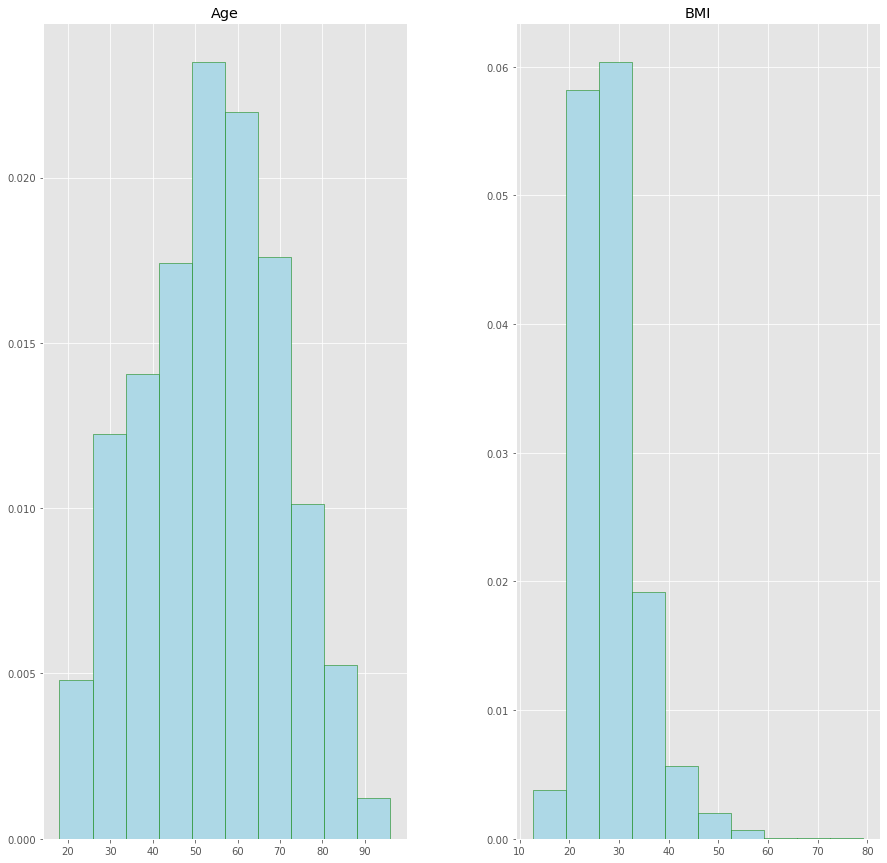

In [32]:
plt.style.use('ggplot')
df[numfeatures].hist(bins =10, figsize = (15,15), density = True, color='lightblue', edgecolor ='green');

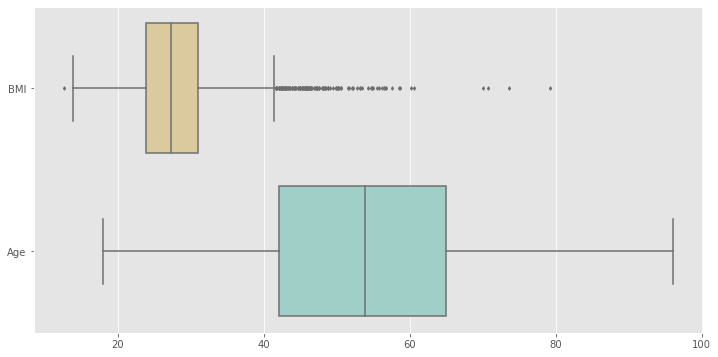

In [33]:
#PBoxplots
numerics = ['BMI', 'Age']
plotnum = df[numerics]
ax = sns.boxplot(data=plotnum, orient="h",fliersize = 2.5, palette="BrBG")
plt.show()

In [34]:
#Impute most outliers with Medians 

#BMI
#print(df['BMI'].quantile(0.50)) 
#print(df['BMI'].quantile(0.95)) 
df['BMI'] = np.where(df['BMI'] > 40, 36.6, df['BMI'])


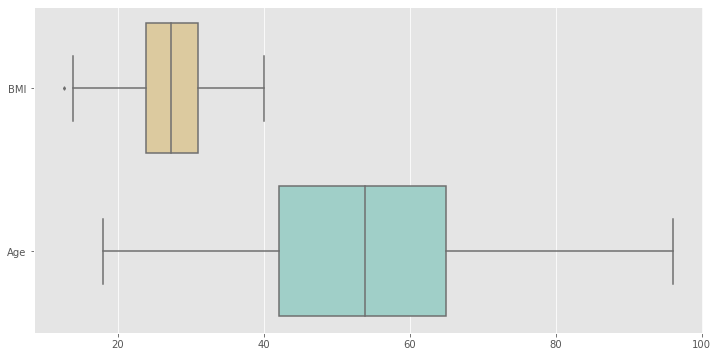

In [35]:
#Check
#PBoxplots
numerics = ['BMI','Age']
plotnum = df[numerics]
#plotnum['SleepWorkdayHr'].describe()
ax = sns.boxplot(data=plotnum, orient="h",fliersize = 2.5, palette="BrBG")
plt.show()

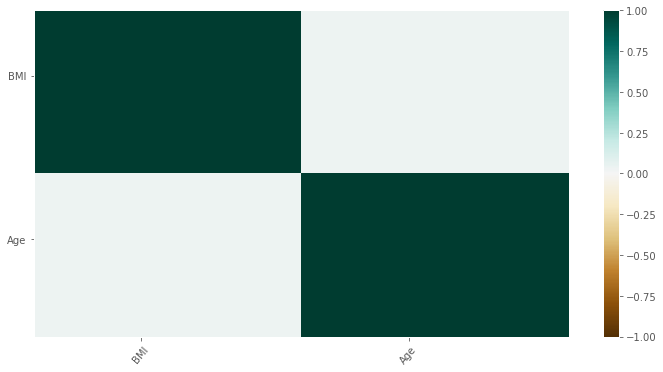

In [219]:
#Heatmap 

#Correlation Matrix and Heat Map
cormat =plotnum.corr()
labels = cormat.columns
fig, ax = plt.subplots()
heatmap = ax.pcolor(cormat, cmap='BrBG', vmin =-1, vmax=1)
ax.set_xticks(np.arange(cormat.shape[0])+0.4)
ax.set_yticks(np.arange(cormat.shape[1])+0.4)
ax.tick_params(axis="x", rotation=50)
ax.invert_yaxis()
ax.set_xticklabels(labels)
ax.set_yticklabels(labels);
plt.colorbar(heatmap)
plt.show()


In [220]:
### Drop some vars due to few respondents...

In [36]:
df.drop(["Good_Health","Asian Indian","" "OtherAsian", "OtherPacificIslander", "MultipleRaces","Samoan","Vietnamese","Mexican","MultipleHispanic","OtherHispanic","Puerto Rican","Asian Indian", "Chinese", "Filipino", "Japanese", "Korean", "OtherAsian", "BornInUsa"], axis = 1, inplace=True)

In [37]:
df.drop(["Asian", "Pacific_Islander"], axis = 1, inplace=True)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 0 to 3629
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    3630 non-null   float64
 1   GeneralHealth          3630 non-null   int64  
 2   IncomeRanges_IMP       3630 non-null   int64  
 3   EducB                  3630 non-null   int64  
 4   RentOrOwn              3630 non-null   int64  
 5   smokeStat              3630 non-null   int64  
 6   BMI                    3630 non-null   float64
 7   TimesModerateExercise  3630 non-null   int64  
 8   Worrying               3630 non-null   int64  
 9   LittleInterest         3630 non-null   int64  
 10  EverythingCauseCancer  3630 non-null   int64  
 11  PreventNotPossible     3630 non-null   int64  
 12  QualityCare            3630 non-null   int64  
 13  SpeakEnglish           3630 non-null   object 
 14  TypeOfAddressC         3630 non-null   int64  
 15  Cell

### Data Splitting

In [39]:
X = df[df.columns[0:31]]
y = df[df.columns[32]]

In [40]:
from sklearn.model_selection import train_test_split

X_test, X_train, y_test, y_train = train_test_split(X,y,test_size=0.2, random_state = 0, stratify= y)

In [41]:
X_test_original = X_test
y_test_original = y_test

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 3332 to 1775
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    726 non-null    float64
 1   GeneralHealth          726 non-null    int64  
 2   IncomeRanges_IMP       726 non-null    int64  
 3   EducB                  726 non-null    int64  
 4   RentOrOwn              726 non-null    int64  
 5   smokeStat              726 non-null    int64  
 6   BMI                    726 non-null    float64
 7   TimesModerateExercise  726 non-null    int64  
 8   Worrying               726 non-null    int64  
 9   LittleInterest         726 non-null    int64  
 10  EverythingCauseCancer  726 non-null    int64  
 11  PreventNotPossible     726 non-null    int64  
 12  QualityCare            726 non-null    int64  
 13  SpeakEnglish           726 non-null    object 
 14  TypeOfAddressC         726 non-null    int64  
 15  Ce

### K-prototype Clustering on mostly integer-represented categorical data 

In [231]:
#Preprocessing numerical

numerical = X_train.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = X_train.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(X_train.select_dtypes(include='object').columns) / df.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

In [236]:
categorical_weight

0.030303030303030304

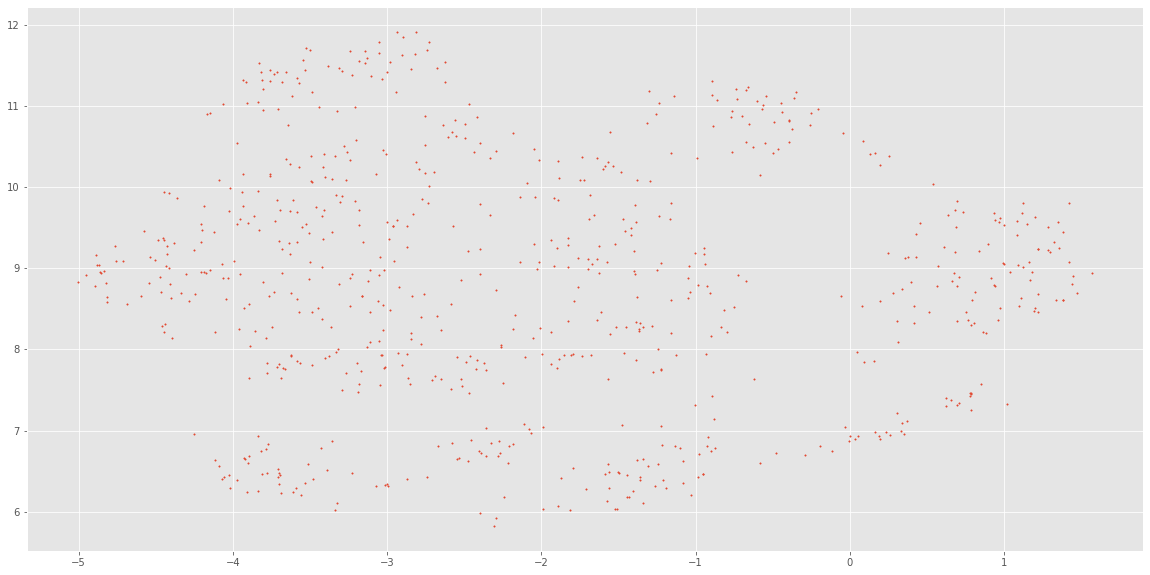

In [237]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False, densmap_kwds = {}, output_dens = False)

embedding = embedding[0]

plt.figure(figsize=(20, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], s=2,cmap='Spectral', alpha=1.0)
plt.show()


In [238]:
kprot_data = X_train.copy()
for c in X_train.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

### Picking number of clusters from the visualization above

In [242]:
categorical_columns = [13]
kproto = KPrototypes(n_clusters= 12, init='Cao', n_jobs = 4) #looks lie 12 clusters 
clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

In [243]:
pd.Series(clusters).value_counts()

11    134
4      91
1      77
0      62
7      62
2      53
8      52
9      48
5      44
3      39
6      33
10     31
dtype: int64

### Using Elbow Method to define clusters

In [241]:
from tqdm import tqdm

costs = []
n_clusters = []
clusters_assigned = []

for i in tqdm(range(2, 30)):
    try:
        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
        clusters = kproto.fit_predict(kprot_data, categorical=[13])
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")
        
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
fig.show()

  0%|          | 0/28 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 165, ncost: 20190.555080205933
Run: 1, iteration: 2/100, moves: 91, ncost: 20003.241815615358
Run: 1, iteration: 3/100, moves: 30, ncost: 19979.725453939176
Run: 1, iteration: 4/100, moves: 13, ncost: 19973.96555932044
Run: 1, iteration: 5/100, moves: 3, ncost: 19972.984711551413
Run: 1, iteration: 6/100, moves: 0, ncost: 19972.984711551413
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 222, ncost: 20133.41791021058
Run: 2, iteration: 2/100, moves: 94, ncost: 20000.488065753954
Run: 2, iteration: 3/100, moves: 31, ncost: 19977.004061467
Run: 2, iteration: 4/100, moves: 8, ncost: 19972.88812609764
Run: 2, iteration: 5/100, moves: 2, ncost: 19972.375972454127
Run: 2, iteration: 6/100, moves: 0, ncost: 19972.375972454127
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, itera

  4%|▎         | 1/28 [00:14<06:25, 14.27s/it]

Run: 10, iteration: 5/100, moves: 0, ncost: 19971.40917326858
Best run was number 4
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 235, ncost: 19532.7880146731
Run: 1, iteration: 2/100, moves: 122, ncost: 19223.914107249868
Run: 1, iteration: 3/100, moves: 53, ncost: 19158.1175747229
Run: 1, iteration: 4/100, moves: 19, ncost: 19133.0039513653
Run: 1, iteration: 5/100, moves: 13, ncost: 19121.581579304864
Run: 1, iteration: 6/100, moves: 6, ncost: 19118.99233783503
Run: 1, iteration: 7/100, moves: 3, ncost: 19118.283474553606
Run: 1, iteration: 8/100, moves: 3, ncost: 19116.673675213337
Run: 1, iteration: 9/100, moves: 3, ncost: 19115.55440636188
Run: 1, iteration: 10/100, moves: 2, ncost: 19114.991146114426
Run: 1, iteration: 11/100, moves: 0, ncost: 19114.991146114426
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 246, ncost: 19330.291403145693
Run: 2, i

  7%|▋         | 2/28 [00:29<06:31, 15.07s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 295, ncost: 18954.849806990358
Run: 1, iteration: 2/100, moves: 138, ncost: 18424.282115402526
Run: 1, iteration: 3/100, moves: 74, ncost: 18254.781841637105
Run: 1, iteration: 4/100, moves: 24, ncost: 18229.422687335322
Run: 1, iteration: 5/100, moves: 13, ncost: 18222.658572763907
Run: 1, iteration: 6/100, moves: 0, ncost: 18222.658572763907
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 297, ncost: 18783.722306856576
Run: 2, iteration: 2/100, moves: 118, ncost: 18582.589945322965
Run: 2, iteration: 3/100, moves: 41, ncost: 18533.457300798
Run: 2, iteration: 4/100, moves: 21, ncost: 18518.798742348223
Run: 2, iteration: 5/100, moves: 12, ncost: 18512.908538911113
Run: 2, iteration: 6/100, moves: 1, ncost: 18512.72742723975
Run: 2, iteration: 7/100, moves: 1, ncost: 18512.43773638609
Run: 2, iteration: 8/100,

 11%|█         | 3/28 [00:48<06:52, 16.48s/it]

Run: 10, iteration: 17/100, moves: 0, ncost: 18211.987314251866
Best run was number 8
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 279, ncost: 18410.927160433046
Run: 1, iteration: 2/100, moves: 146, ncost: 17983.023061092164
Run: 1, iteration: 3/100, moves: 61, ncost: 17869.63631518081
Run: 1, iteration: 4/100, moves: 23, ncost: 17855.928496431996
Run: 1, iteration: 5/100, moves: 11, ncost: 17848.704430187987
Run: 1, iteration: 6/100, moves: 8, ncost: 17844.920202160207
Run: 1, iteration: 7/100, moves: 4, ncost: 17842.604326576504
Run: 1, iteration: 8/100, moves: 5, ncost: 17838.746631804013
Run: 1, iteration: 9/100, moves: 4, ncost: 17836.269430345583
Run: 1, iteration: 10/100, moves: 1, ncost: 17835.712583154807
Run: 1, iteration: 11/100, moves: 2, ncost: 17835.147745350718
Run: 1, iteration: 12/100, moves: 0, ncost: 17835.147745350718
Init: initializing centroids
Init: initializing clusters
Starting iterations...
R

 14%|█▍        | 4/28 [01:07<07:00, 17.53s/it]

Run: 10, iteration: 10/100, moves: 2, ncost: 17923.205780402786
Run: 10, iteration: 11/100, moves: 0, ncost: 17923.205780402786
Best run was number 3
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 323, ncost: 17944.68483745521
Run: 1, iteration: 2/100, moves: 123, ncost: 17645.821419992335
Run: 1, iteration: 3/100, moves: 60, ncost: 17474.49125014058
Run: 1, iteration: 4/100, moves: 46, ncost: 17411.802121265468
Run: 1, iteration: 5/100, moves: 14, ncost: 17401.84490268541
Run: 1, iteration: 6/100, moves: 5, ncost: 17399.488367636342
Run: 1, iteration: 7/100, moves: 7, ncost: 17396.389567211394
Run: 1, iteration: 8/100, moves: 8, ncost: 17390.607085893545
Run: 1, iteration: 9/100, moves: 5, ncost: 17386.54829577384
Run: 1, iteration: 10/100, moves: 1, ncost: 17385.678906283334
Run: 1, iteration: 11/100, moves: 0, ncost: 17385.678906283334
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run

 18%|█▊        | 5/28 [01:28<07:13, 18.84s/it]

Run: 10, iteration: 17/100, moves: 0, ncost: 17230.914181712385
Best run was number 10
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 329, ncost: 17310.810021984038
Run: 1, iteration: 2/100, moves: 117, ncost: 17059.011344104045
Run: 1, iteration: 3/100, moves: 64, ncost: 16940.47061410586
Run: 1, iteration: 4/100, moves: 22, ncost: 16889.18564167737
Run: 1, iteration: 5/100, moves: 3, ncost: 16886.890587386788
Run: 1, iteration: 6/100, moves: 1, ncost: 16886.14782844928
Run: 1, iteration: 7/100, moves: 0, ncost: 16886.14782844928
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 321, ncost: 17585.046695446403
Run: 2, iteration: 2/100, moves: 123, ncost: 17283.430997153482
Run: 2, iteration: 3/100, moves: 70, ncost: 17134.64479403261
Run: 2, iteration: 4/100, moves: 31, ncost: 17092.437192392863
Run: 2, iteration: 5/100, moves: 32, ncost: 17050.630019988806
R

 21%|██▏       | 6/28 [01:47<06:53, 18.81s/it]

Run: 10, iteration: 11/100, moves: 0, ncost: 16830.45242060813
Best run was number 8
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 313, ncost: 16955.944768447545
Run: 1, iteration: 2/100, moves: 110, ncost: 16619.546885805918
Run: 1, iteration: 3/100, moves: 42, ncost: 16533.948940948936
Run: 1, iteration: 4/100, moves: 27, ncost: 16484.374604688917
Run: 1, iteration: 5/100, moves: 12, ncost: 16460.408326894347
Run: 1, iteration: 6/100, moves: 4, ncost: 16455.63579971277
Run: 1, iteration: 7/100, moves: 1, ncost: 16455.325496702306
Run: 1, iteration: 8/100, moves: 0, ncost: 16455.325496702306
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 288, ncost: 17170.68687226771
Run: 2, iteration: 2/100, moves: 109, ncost: 16920.53980992754
Run: 2, iteration: 3/100, moves: 44, ncost: 16799.77665884668
Run: 2, iteration: 4/100, moves: 32, ncost: 16748.63379064202
Run

 25%|██▌       | 7/28 [02:07<06:47, 19.39s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 344, ncost: 16814.97541647391
Run: 1, iteration: 2/100, moves: 135, ncost: 16390.884169897883
Run: 1, iteration: 3/100, moves: 67, ncost: 16273.55242641537
Run: 1, iteration: 4/100, moves: 41, ncost: 16186.799128039918
Run: 1, iteration: 5/100, moves: 23, ncost: 16152.335153437542
Run: 1, iteration: 6/100, moves: 5, ncost: 16149.213234935705
Run: 1, iteration: 7/100, moves: 3, ncost: 16148.221427586532
Run: 1, iteration: 8/100, moves: 0, ncost: 16148.221427586532
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 352, ncost: 16872.570052795745
Run: 2, iteration: 2/100, moves: 156, ncost: 16431.98952151803
Run: 2, iteration: 3/100, moves: 95, ncost: 16232.940181487755
Run: 2, iteration: 4/100, moves: 43, ncost: 16182.861646212252
Run: 2, iteration: 5/100, moves: 17, ncost: 16144.49545204259
Run: 2, iteration: 6/100

 29%|██▊       | 8/28 [02:26<06:26, 19.35s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 336, ncost: 16800.915338151157
Run: 1, iteration: 2/100, moves: 136, ncost: 16442.99688920861
Run: 1, iteration: 3/100, moves: 53, ncost: 16328.051173093407
Run: 1, iteration: 4/100, moves: 32, ncost: 16255.598396852465
Run: 1, iteration: 5/100, moves: 56, ncost: 16075.324436137647
Run: 1, iteration: 6/100, moves: 63, ncost: 15923.730516008165
Run: 1, iteration: 7/100, moves: 10, ncost: 15909.334238841357
Run: 1, iteration: 8/100, moves: 12, ncost: 15893.332768488674
Run: 1, iteration: 9/100, moves: 5, ncost: 15889.635252230193
Run: 1, iteration: 10/100, moves: 0, ncost: 15889.635252230193
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 324, ncost: 16323.407345117206
Run: 2, iteration: 2/100, moves: 140, ncost: 15933.64246711245
Run: 2, iteration: 3/100, 

 32%|███▏      | 9/28 [02:48<06:19, 19.96s/it]

Run: 10, iteration: 8/100, moves: 0, ncost: 15787.422023161293
Best run was number 7
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 337, ncost: 16133.21030818042
Run: 1, iteration: 2/100, moves: 129, ncost: 15764.710754091158
Run: 1, iteration: 3/100, moves: 69, ncost: 15552.218788910228
Run: 1, iteration: 4/100, moves: 30, ncost: 15484.669831250934
Run: 1, iteration: 5/100, moves: 11, ncost: 15474.41038280632
Run: 1, iteration: 6/100, moves: 9, ncost: 15464.379245220995
Run: 1, iteration: 7/100, moves: 10, ncost: 15452.177284781406
Run: 1, iteration: 8/100, moves: 11, ncost: 15435.687589357209
Run: 1, iteration: 9/100, moves: 15, ncost: 15420.956086241691
Run: 1, iteration: 10/100, moves: 18, ncost: 15402.693012971975
Run: 1, iteration: 11/100, moves: 9, ncost: 15394.040023317355
Run: 1, iteration: 12/100, moves: 7, ncost: 15387.1847290984
Run: 1, iteration: 13/100, moves: 2, ncost: 15384.027947890087
Run: 1, iteration:

 36%|███▌      | 10/28 [03:10<06:14, 20.79s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 373, ncost: 16020.235426230834
Run: 1, iteration: 2/100, moves: 127, ncost: 15626.189143336978
Run: 1, iteration: 3/100, moves: 72, ncost: 15370.899725308404
Run: 1, iteration: 4/100, moves: 61, ncost: 15147.03053831862
Run: 1, iteration: 5/100, moves: 30, ncost: 15048.049486677739
Run: 1, iteration: 6/100, moves: 5, ncost: 15039.00639549041
Run: 1, iteration: 7/100, moves: 1, ncost: 15037.260808773955
Run: 1, iteration: 8/100, moves: 0, ncost: 15037.260808773955
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 328, ncost: 16347.401810102112
Run: 2, iteration: 2/100, moves: 161, ncost: 15828.132218959501
Run: 2, iteration: 3/100, moves: 71, ncost: 15665.336338107696
Run: 2, iteration: 4/100, moves: 33, ncost: 15599.026591916974
Run: 2, iteration: 5/100, moves: 14, ncost: 15574.778465804036
Run: 2, iteration: 6/1

 39%|███▉      | 11/28 [03:33<06:01, 21.26s/it]

Run: 10, iteration: 15/100, moves: 0, ncost: 15126.830111740419
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 376, ncost: 15964.781529507694
Run: 1, iteration: 2/100, moves: 146, ncost: 15361.618398617558
Run: 1, iteration: 3/100, moves: 52, ncost: 15201.777378469362
Run: 1, iteration: 4/100, moves: 15, ncost: 15183.201397632532
Run: 1, iteration: 5/100, moves: 7, ncost: 15172.192859754354
Run: 1, iteration: 6/100, moves: 8, ncost: 15162.780637534981
Run: 1, iteration: 7/100, moves: 3, ncost: 15159.126815306743
Run: 1, iteration: 8/100, moves: 4, ncost: 15155.957593478654
Run: 1, iteration: 9/100, moves: 8, ncost: 15146.390811452096
Run: 1, iteration: 10/100, moves: 9, ncost: 15138.811106316396
Run: 1, iteration: 11/100, moves: 14, ncost: 15125.592893165182
Run: 1, iteration: 12/100, moves: 14, ncost: 15111.823844440087
Run: 1, iteration: 13/100, moves: 8, ncost: 15104.933581111234
Run: 1, iteratio

 43%|████▎     | 12/28 [03:56<05:48, 21.78s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 375, ncost: 15890.774565642194
Run: 1, iteration: 2/100, moves: 155, ncost: 15334.87101922347
Run: 1, iteration: 3/100, moves: 90, ncost: 15048.673280230698
Run: 1, iteration: 4/100, moves: 49, ncost: 14915.839437243287
Run: 1, iteration: 5/100, moves: 30, ncost: 14854.412030259798
Run: 1, iteration: 6/100, moves: 14, ncost: 14824.37194720154
Run: 1, iteration: 7/100, moves: 7, ncost: 14817.395274638582
Run: 1, iteration: 8/100, moves: 10, ncost: 14809.812114709375
Run: 1, iteration: 9/100, moves: 6, ncost: 14805.494952884645
Run: 1, iteration: 10/100, moves: 9, ncost: 14798.796208666714
Run: 1, iteration: 11/100, moves: 7, ncost: 14792.973454803363
Run: 1, iteration: 12/100, moves: 8, ncost: 14786.127981661946
Run: 1, iteration: 13/100, moves: 3, ncost: 14782.090931505687
Run: 1, iteration: 14/100, moves: 1, ncost: 14780.833715577413
Run: 1, iteration: 15/100, moves: 0, nco

 46%|████▋     | 13/28 [04:19<05:35, 22.34s/it]

Run: 10, iteration: 10/100, moves: 0, ncost: 14802.594763611443
Best run was number 9
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 376, ncost: 15392.1420623828
Run: 1, iteration: 2/100, moves: 154, ncost: 14863.248565376794
Run: 1, iteration: 3/100, moves: 61, ncost: 14742.837893267679
Run: 1, iteration: 4/100, moves: 30, ncost: 14690.266737446736
Run: 1, iteration: 5/100, moves: 17, ncost: 14668.091122882368
Run: 1, iteration: 6/100, moves: 9, ncost: 14661.14124505534
Run: 1, iteration: 7/100, moves: 10, ncost: 14653.31491386742
Run: 1, iteration: 8/100, moves: 5, ncost: 14648.867719438096
Run: 1, iteration: 9/100, moves: 6, ncost: 14638.179064943037
Run: 1, iteration: 10/100, moves: 3, ncost: 14633.7036126102
Run: 1, iteration: 11/100, moves: 11, ncost: 14612.457338355103
Run: 1, iteration: 12/100, moves: 17, ncost: 14549.300842317267
Run: 1, iteration: 13/100, moves: 26, ncost: 14456.921288820735
Run: 1, iteration: 

Run: 10, iteration: 3/100, moves: 56, ncost: 14945.102535731394
Run: 10, iteration: 4/100, moves: 24, ncost: 14893.019331318674
Run: 10, iteration: 5/100, moves: 11, ncost: 14879.269788520593
Run: 10, iteration: 6/100, moves: 8, ncost: 14869.47387979692


 50%|█████     | 14/28 [04:45<05:26, 23.30s/it]

Run: 10, iteration: 7/100, moves: 0, ncost: 14869.47387979692
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 383, ncost: 15319.212691841076
Run: 1, iteration: 2/100, moves: 142, ncost: 14843.283242519023
Run: 1, iteration: 3/100, moves: 49, ncost: 14762.472089978175
Run: 1, iteration: 4/100, moves: 17, ncost: 14739.836152331161
Run: 1, iteration: 5/100, moves: 17, ncost: 14713.368750068128
Run: 1, iteration: 6/100, moves: 31, ncost: 14623.048159034663
Run: 1, iteration: 7/100, moves: 24, ncost: 14518.87783751308
Run: 1, iteration: 8/100, moves: 10, ncost: 14503.824890447006
Run: 1, iteration: 9/100, moves: 13, ncost: 14484.297018424533
Run: 1, iteration: 10/100, moves: 9, ncost: 14472.921396196161
Run: 1, iteration: 11/100, moves: 6, ncost: 14469.913791041987
Run: 1, iteration: 12/100, moves: 1, ncost: 14469.20291242939
Run: 1, iteration: 13/100, moves: 0, ncost: 14469.20291242939
Init: initializing

 54%|█████▎    | 15/28 [05:08<05:00, 23.12s/it]

Run: 10, iteration: 13/100, moves: 0, ncost: 14495.441508181411
Best run was number 6
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 420, ncost: 14824.025018054748
Run: 1, iteration: 2/100, moves: 127, ncost: 14452.310834052152
Run: 1, iteration: 3/100, moves: 39, ncost: 14352.38429824527
Run: 1, iteration: 4/100, moves: 19, ncost: 14295.302478154617
Run: 1, iteration: 5/100, moves: 23, ncost: 14205.277930012187
Run: 1, iteration: 6/100, moves: 23, ncost: 14166.439482886726
Run: 1, iteration: 7/100, moves: 12, ncost: 14148.888059419869
Run: 1, iteration: 8/100, moves: 6, ncost: 14139.622179868806
Run: 1, iteration: 9/100, moves: 1, ncost: 14139.329593766033
Run: 1, iteration: 10/100, moves: 0, ncost: 14139.329593766033
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init:

 57%|█████▋    | 16/28 [05:29<04:32, 22.68s/it]

Run: 10, iteration: 15/100, moves: 4, ncost: 14301.557494233444
Run: 10, iteration: 16/100, moves: 0, ncost: 14301.557494233444
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 340, ncost: 14889.080088172075
Run: 1, iteration: 2/100, moves: 139, ncost: 14378.70122373119
Run: 1, iteration: 3/100, moves: 73, ncost: 14204.650268554597
Run: 1, iteration: 4/100, moves: 52, ncost: 14125.071649638794
Run: 1, iteration: 5/100, moves: 16, ncost: 14110.803654134977
Run: 1, iteration: 6/100, moves: 7, ncost: 14104.391423664078
Run: 1, iteration: 7/100, moves: 5, ncost: 14100.937040540468
Run: 1, iteration: 8/100, moves: 8, ncost: 14093.940037201308
Run: 1, iteration: 9/100, moves: 11, ncost: 14078.028286563438
Run: 1, iteration: 10/100, moves: 8, ncost: 14070.03117519014
Run: 1, iteration: 11/100, moves: 4, ncost: 14065.013815483224
Run: 1, iteration: 12/100, moves: 3, ncost: 14063.124370892045
Run: 1, iteration

 61%|██████    | 17/28 [05:53<04:14, 23.16s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 345, ncost: 15201.417601487274
Run: 1, iteration: 2/100, moves: 120, ncost: 14634.322547829684
Run: 1, iteration: 3/100, moves: 74, ncost: 14333.3726474517
Run: 1, iteration: 4/100, moves: 31, ncost: 14236.796128248772
Run: 1, iteration: 5/100, moves: 14, ncost: 14188.400162904654
Run: 1, iteration: 6/100, moves: 7, ncost: 14153.879640917563
Run: 1, iteration: 7/100, moves: 9, ncost: 14132.456742105027
Run: 1, iteration: 8/100, moves: 12, ncost: 14106.775541637735
Run: 1, iteration: 9/100, moves: 7, ncost: 14091.160910229444
Run: 1, iteration: 10/100, moves: 6, ncost: 14064.956042632557
Run: 1, iteration: 11/100, moves: 4, ncost: 14035.912463400367
Run: 1, iteration: 12/100, moves: 5, ncost: 14017.633115026441
Run: 1, iteration: 13/100, moves: 0, ncost: 14017.633115026441
Init: initializing centroids
Init: initializing

 64%|██████▍   | 18/28 [06:18<03:56, 23.68s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 366, ncost: 14684.517574658585
Run: 1, iteration: 2/100, moves: 129, ncost: 14290.070869020228
Run: 1, iteration: 3/100, moves: 53, ncost: 14131.549739591324
Run: 1, iteration: 4/100, moves: 41, ncost: 14017.315780230663
Run: 1, iteration: 5/100, moves: 19, ncost: 13973.878832152184
Run: 1, iteration: 6/100, moves: 3, ncost: 13970.794686786568
Run: 1, iteration: 7/100, moves: 0, ncost: 13970.794686786568
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 359, ncost: 15086.711540969356
Run: 2, iteration: 2/100, moves: 152, ncost: 14510.247368773369
Run: 2, iteration: 3/100, moves: 63, ncost: 14326.71230417925
Run: 2, iteration: 4/100, moves: 40, ncost: 14248.739057944746
Run: 2, iteration: 5/100, moves: 16, ncost: 14228.952773584775
Run: 2, iteration: 6/100, moves: 11, ncost: 14219.495708375725
Run: 2, iteration: 7

 68%|██████▊   | 19/28 [06:40<03:28, 23.13s/it]

Run: 10, iteration: 9/100, moves: 0, ncost: 13742.60193562284
Best run was number 5
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 389, ncost: 14483.28156508519
Run: 1, iteration: 2/100, moves: 150, ncost: 13975.1363089967
Run: 1, iteration: 3/100, moves: 68, ncost: 13795.119844609455
Run: 1, iteration: 4/100, moves: 26, ncost: 13736.070192555613
Run: 1, iteration: 5/100, moves: 12, ncost: 13706.254974887475
Run: 1, iteration: 6/100, moves: 1, ncost: 13704.268010032938
Run:

 71%|███████▏  | 20/28 [07:02<03:01, 22.70s/it]

Run: 10, iteration: 8/100, moves: 0, ncost: 13799.707796138886
Best run was number 6
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 357, ncost: 14543.958931226907
Run: 1, iteration: 2/100, moves: 123, ncost: 14230.085497294569
Run: 1, iteration: 3/100, moves: 54, ncost: 14044.972984800617
Run: 1, iteration: 4/100, moves: 33, ncost: 13940.72495056754
Run: 1, iteration: 5/100, moves: 21, ncost: 13885.906232357733
Run: 1, iteration: 6/100, moves: 14, ncost: 13862.42148466015
Run: 1, iteration: 7/100, moves: 3, ncost: 13854.39703548217
Run: 1, iteration: 8/100, moves: 5, ncost: 13836.196090327654
Run: 1, iteration: 9/100, moves: 5, ncost: 13823.202151069538
Run: 1, iteration: 10/100, moves: 5, ncost: 13812.870720536417
Run: 1, iteration: 11/100, moves: 4, ncost: 13807.543297285662
Run: 1, iteration: 12/100, moves: 0, ncost: 13807.543297285662
Init: initializing centroi

 75%|███████▌  | 21/28 [07:24<02:36, 22.41s/it]

Run: 10, iteration: 14/100, moves: 0, ncost: 13864.676996562574
Best run was number 4
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 345, ncost: 14307.369842507707
Run: 1, iteration: 2/100, moves: 165, ncost: 13703.464331232966
Run: 1, iteration: 3/100, moves: 79, ncost: 13537.398983842071
Run: 1, iteration: 4/100, moves: 36, ncost: 13444.469357031398
Run: 1, iteration: 5/100, moves: 20, ncost: 13373.987167134203
Run: 1, iteration: 6/100, moves: 3, ncost: 13369.621926530483
Run: 1, iteration: 7/100, moves: 1, ncost: 13369.176603496247
Run: 1, iteration: 8/100, moves: 0, ncost: 13369.176603496247
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 362, ncost: 14158.55787513682
Run: 2, iteration

 79%|███████▊  | 22/28 [07:46<02:13, 22.31s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 355, ncost: 14284.244978479219
Run: 1, iteration: 2/100, moves: 165, ncost: 13687.35416703041
Run: 1, iteration: 3/100, moves: 44, ncost: 13593.654896073625
Run: 1, iteration: 4/100, moves: 6, ncost: 13580.91747127452
Run: 1, iteration: 5/100, moves: 1, ncost: 13580.154846452211
Run: 1, iteration: 6/100, moves: 0, ncost: 13580.154846452211
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 384, ncost: 13913.050581769377
Run: 2, iteration: 2/100, moves: 110, ncost: 13521.601211034076
Run: 2, iteration: 3/100, moves: 42, ncost: 13424.544784631724
Run: 2, iteration: 4/100, moves: 21, ncost: 13

 82%|████████▏ | 23/28 [08:07<01:49, 21.90s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 356, ncost: 14199.840077205366
Run: 1, iteration: 2/100, moves: 109, ncost: 13836.184090772773
Run: 1, iteration: 3/100, moves: 71, ncost: 13542.5725965119
Run: 1, iteration: 4/100, moves: 22, ncost: 13508.534230068733
Run: 1, iteration: 5/100, moves: 7, ncost: 13500.283686319965
Run: 1, iteration: 6/100, moves: 0, ncost: 13500.283686319965
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 378, ncost: 14214.130833798261
Run: 2, iteration: 2/100, moves: 151, ncost: 13522.424837097837
Run: 2, iteration: 3/100, moves: 50, ncost: 13384.544170296314
Run: 2, iteration: 4/100, moves: 26, ncost: 13327.657733573744
Run: 2, iteration: 5/100, moves: 21, ncost: 13276.038426024557
Run: 2, iteration: 6/100, moves: 

 86%|████████▌ | 24/28 [08:31<01:30, 22.52s/it]

Run: 10, iteration: 13/100, moves: 0, ncost: 13318.603684938858
Best run was number 2
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 380, ncost: 14015.556261169446
Run: 1, iteration: 2/100, moves: 129, ncost: 13515.526239078492
Run: 1, iteration: 3/100, moves: 44, ncost: 13399.486447121162
Run: 1, iteration: 4/100, moves: 20, ncost: 13360.10399064028
Run: 1, iteration: 5/100, moves: 19, ncost: 13296.85519195561
Run: 1, iteration: 6/100, moves: 13, ncost: 13276.116427307443
Run: 1, iteration: 7/100, moves: 9, ncost: 13261.813185415363
Run: 1, iteration: 8/100, moves: 6, ncost: 13251.248721747075
Run: 1, iteration: 9/100, moves: 3, ncost: 13245.023577386886
Run: 1, iteration: 10/100, moves: 5, ncost: 13237.19578796327
Run: 1, iteration: 11/100, moves: 4, ncost: 13233.484981240272
Run: 1, iteration: 12/100, moves: 3, ncost: 13231.668863487355
Run: 1, iteration: 13/100, moves: 2, ncost: 13230.118096730524
Run: 1, iteration: 

 89%|████████▉ | 25/28 [08:56<01:09, 23.26s/it]

Run: 10, iteration: 7/100, moves: 0, ncost: 13292.114839182883
Best run was number 7
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 366, ncost: 13993.459116932801
Run: 1, iteration: 2/100, moves: 142, ncost: 13414.013137130338
Run: 1, iteration: 3/100, moves: 55, ncost: 13282.177495144093
Run: 1, iteration: 4/100, moves: 22, ncost: 13242.934798649396
Run: 1, iteration: 5/100, moves: 11, ncost: 13221.765480928727
Run: 1, iteration: 6/100, moves: 10, ncost: 13198.88390524394
Run: 1, iteration: 7/100, moves: 10, ncost: 13166.498053709305
Run: 1, iteration: 8/100, moves: 4, ncost: 13164.102577076746
Run: 1, iteration: 9/100, moves: 4, ncost: 13161.689249328223
Run: 1, iteration: 10/100, moves: 4, ncost: 13159.481567085799
Run: 1, iteration: 11/100, moves: 1, ncost: 13158.659379176554
Run: 1, iteration: 12/100, moves: 0, ncost: 13158.659379176554
Init: initializing cent

 93%|█████████▎| 26/28 [09:18<00:46, 23.11s/it]

Run: 10, iteration: 11/100, moves: 0, ncost: 13226.408032712185
Best run was number 9
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 324, ncost: 14102.184426096643
Run: 1, iteration: 2/100, moves: 138, ncost: 13521.142098179593
Run: 1, iteration: 3/100, moves: 78, ncost: 13271.878882969766
Run: 1, iteration: 4/100, moves: 23, ncost: 13229.4020216607
Run: 1, iteration: 5/100, moves: 9, ncost: 13215.626785374452
Run: 1, iteration: 6/100, moves: 4, ncost: 13211.666778205297
Run: 1, iteration: 7/100, moves: 1, ncost: 13211.163164252059
Run: 1, iteration: 8/100, moves: 0, ncost: 13211.163164252059
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing c

 96%|█████████▋| 27/28 [09:43<00:23, 23.64s/it]

Run: 10, iteration: 12/100, moves: 0, ncost: 12977.751952483708
Best run was number 10
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 356, ncost: 13985.568384234622
Run: 1, iteration: 2/100, moves: 148, ncost: 13341.288735027943
Run: 1, iteration: 3/100, moves: 70, ncost: 13152.754792368538
Run: 1, iteration: 4/100, moves: 25, ncost: 13096.09334719175
Run: 1, iteration: 5/100, moves: 4, ncost: 13089.439203694134
Run: 1, iteration: 6/100, moves: 1, ncost: 13088.295656382428
Run: 1, iteration: 7/100, moves: 0, ncost: 13088.295656382428
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clus

100%|██████████| 28/28 [10:07<00:00, 21.71s/it]

Run: 10, iteration: 10/100, moves: 0, ncost: 13121.486777582728
Best run was number 8


### Picking 23 clusters from Elbow Method

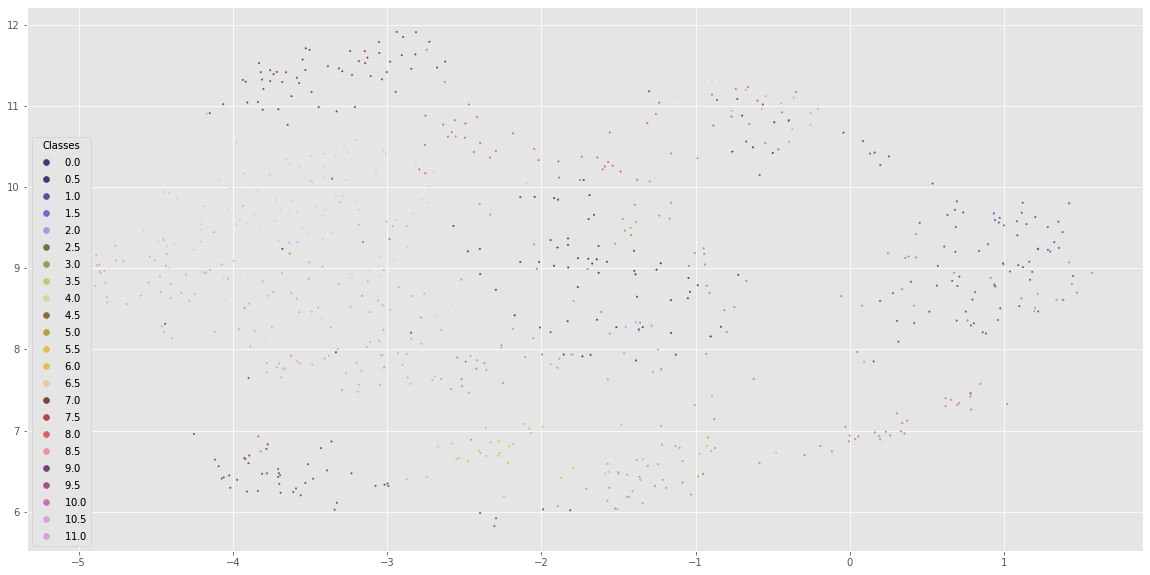

In [246]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=23),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

### Clustering Algorithm on majority categorical data (object) and 2 continuous variables(age and BMI)

In [249]:
#converting back to object datatype
allFeatures=X_train.columns[1:len(df.columns)]
numfeatures =X_train.columns[list(range(0,1))+list(range(6,7))]

print(numfeatures)

catfeatures= [i for i in allFeatures if not(i in numfeatures)]

print(catfeatures)

Index(['Age', 'BMI'], dtype='object')
['GeneralHealth', 'IncomeRanges_IMP', 'EducB', 'RentOrOwn', 'smokeStat', 'TimesModerateExercise', 'Worrying', 'LittleInterest', 'EverythingCauseCancer', 'PreventNotPossible', 'QualityCare', 'SpeakEnglish', 'TypeOfAddressC', 'CellPhone', 'Diabetes', 'HighBP', 'HeartCondition', 'LungDisease', 'Arthritis', 'Depression', 'Cancer', 'EmotionalSupport', 'RegularProvider', 'HealthInsurance', 'Deaf', 'Blind', 'Black', 'White', 'Not Hispanic']


In [250]:
for c in catfeatures:
    X_train[c]=X_train[c].astype('object')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 0 to 3629
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    3630 non-null   float64
 1   GeneralHealth          3630 non-null   object 
 2   IncomeRanges_IMP       3630 non-null   object 
 3   EducB                  3630 non-null   object 
 4   RentOrOwn              3630 non-null   object 
 5   smokeStat              3630 non-null   object 
 6   BMI                    3630 non-null   float64
 7   TimesModerateExercise  3630 non-null   object 
 8   Worrying               3630 non-null   object 
 9   LittleInterest         3630 non-null   object 
 10  EverythingCauseCancer  3630 non-null   object 
 11  PreventNotPossible     3630 non-null   object 
 12  QualityCare            3630 non-null   object 
 13  SpeakEnglish           3630 non-null   object 
 14  TypeOfAddressC         3630 non-null   object 
 15  Cell

In [251]:
from sklearn.preprocessing import PowerTransformer
import umap
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

In [261]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 3332 to 1775
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    726 non-null    float64
 1   GeneralHealth          726 non-null    object 
 2   IncomeRanges_IMP       726 non-null    object 
 3   EducB                  726 non-null    object 
 4   RentOrOwn              726 non-null    object 
 5   smokeStat              726 non-null    object 
 6   BMI                    726 non-null    float64
 7   TimesModerateExercise  726 non-null    object 
 8   Worrying               726 non-null    object 
 9   LittleInterest         726 non-null    object 
 10  EverythingCauseCancer  726 non-null    object 
 11  PreventNotPossible     726 non-null    object 
 12  QualityCare            726 non-null    object 
 13  SpeakEnglish           726 non-null    object 
 14  TypeOfAddressC         726 non-null    object 
 15  Ce

In [262]:
#Preprocessing numerical

numerical = X_train.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = X_train.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(X_train.select_dtypes(include='object').columns) / df.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

In [254]:
### Weight of cat features increased

In [263]:
categorical_weight

0.8787878787878788

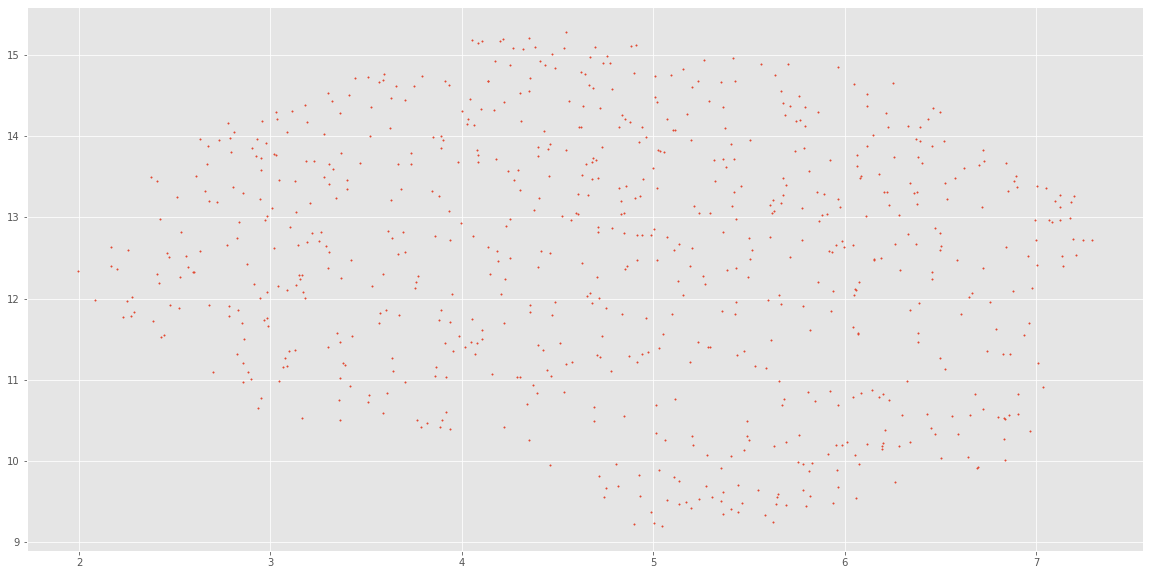

In [264]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False, densmap_kwds = {}, output_dens = False)

embedding = embedding[0]

plt.figure(figsize=(20, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], s=2,cmap='Spectral', alpha=1.0)
plt.show()



In [265]:
kprot_data = X_train.copy()
for c in X_train.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

In [270]:
categorical_columns = [1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
kproto = KPrototypes(n_clusters= 4, init='Cao', n_jobs = 4) #maybe 3 clusters really?
clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

In [271]:
pd.Series(clusters).value_counts()

3    261
1    158
0    156
2    151
dtype: int64

### Using classifier to predict cluster label

In [273]:
from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score

#Setting the objects to category 
lgbm_data = X_train.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')
    

In [274]:
categorical_columns = [1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

In [275]:
kproto = KPrototypes(n_clusters= 15, init='Cao', n_jobs = 4)
clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)


In [276]:
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data,clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes clusters is 0.5999048301619678


In [277]:
clf_kp.fit(lgbm_data,clusters)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


LGBMClassifier(colsample_by_tree=0.8)

In [278]:
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)

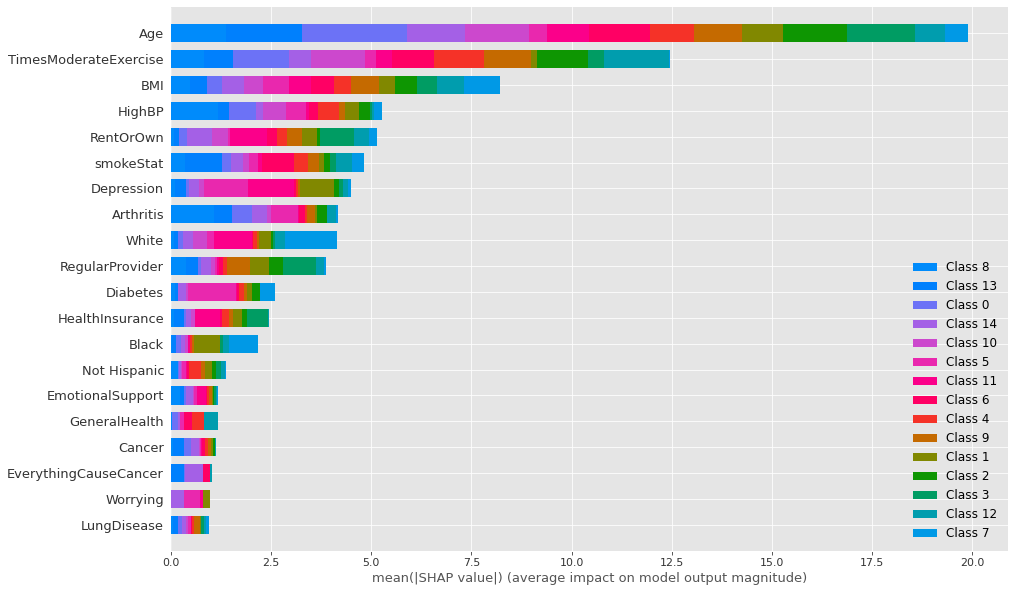

In [279]:
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10))

In [146]:
X_train = X_train.drop(['Cluster Labels','Segment'], axis =1)

In [150]:
y_train

y_train=y_train.astype('int')

### Oversample target variable in training data via SMOTE on Training Data Only
There is an imbalance in the derived variable 'fatalviews'. So I will use the SMOTE algorithm to oversample the underrepresented class.

In [43]:
#SMOTE to oversample class 0 in Good_Health among those who have Cancer 

#cat_cols = X_train.select_dtypes(include = 'object').columns 
X_train = pd.get_dummies(X_train) 

#Drop colinear vars
#df_cancer = df_cancer.drop(['Age_group','GeneralHealth', 'Education', 'SpeakEnglish'], axis =1)

from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0, sampling_strategy = 0.8)

#oversample on the training data 
os_data_X, os_data_y = os.fit_resample(X_train, y_train)

#os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
#os_data_y= pd.DataFrame(data=os_data_y, columns=['fatalview'])

#Check Numbers
#print("length of oversampled data: ",len(os_data_X))
#print("Count of 0's (Not-fatalview) in oversampled data",len(os_data_y[os_data_y['fatalview']==0]))
#print("Count of Good Health",len(os_data_y[os_data_y['fatalview']==1]))

In [44]:
os_data_y

0       1
1       0
2       0
3       0
4       1
       ..
1028    1
1029    1
1030    1
1031    1
1032    1
Name: fatalview, Length: 1033, dtype: int64

In [45]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap

In [46]:
scalor=StandardScaler()
cv_outer = StratifiedKFold(n_splits=9, shuffle=True, random_state=1)
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

### RF

In [47]:
model_rf=RandomForestClassifier(random_state=1)
rf_pipeline = Pipeline([ 
    ('pca', PCA()), 
    ('model_rf',model_rf)
 ])
rf_param = {
               'pca__n_components': [0.60,0.70,0.80,0.90],
                'model_rf__bootstrap': [True, False],
                'model_rf__max_depth': [2, 3, 5,7,9],
               'model_rf__max_features': ['auto', 'sqrt'],
                'model_rf__n_estimators': [10, 100, 500]}

rf_random = RandomizedSearchCV(rf_pipeline, rf_param, cv=cv_inner, scoring='f1')

### XGboost

In [48]:
model_xgb = xgb.XGBClassifier(random_state=1,objective='binary:logistic',eval_metric='logloss',use_label_encoder=False)
xgb_pipeline = Pipeline([
     ('pca', PCA()), 
     ('model_xgb', model_xgb)
 ])

xgb_param= {
     'pca__n_components': [0.60,0.70,0.80,0.90],
     'model_xgb__max_depth': [2, 3, 5,7,9],
     'model_xgb__n_estimators': [10, 100, 500]}
xgb_random = RandomizedSearchCV(xgb_pipeline, xgb_param, cv=cv_inner, scoring='f1')

### Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression

#model
model_logistic=LogisticRegression(random_state=1, solver = 'liblinear')

#pipeline

logistic_pipeline = Pipeline([  
    ('pca', PCA()),
    ('model_logistic',model_logistic)
])

#hyper parameters
logistic_param = {
               'pca__n_components': [0.60,0.70,0.80,0.90],
               'model_logistic__penalty': ['l2', 'l1']
}


#find best hp
logistic_random = RandomizedSearchCV(logistic_pipeline, logistic_param, cv= cv_inner, scoring='f1')

### Bootstrapping using the balanced X and balanaced Y data that came from the Original Split Training Data

In [50]:
#os_data_X, os_data_y

import pandas as pd
from sklearn.utils import resample

Index=range(0,len(os_data_X)) #generates 
print(Index)

#Create Lists 
inbags =[]
outbags=[]

for it in range(0, 10):
    boot = resample(Index, replace=True, n_samples= len(os_data_X), random_state =1 ) #create inbag with n_samples size of data, with replacement
    
    #Link to ground truth 
    x_inbag = os_data_X.iloc[boot, : ]
    y_inbag = os_data_y.iloc[boot]

    # out of bag observations
    oob = [x for x in Index if x not in boot] #creates out bag based on what's not in the inbag
    x_obag = os_data_X.iloc[oob, : ] #links to ground truth
    y_obag = os_data_y.iloc[oob]
    
    #append in and out bags
    inbags.append([x_inbag, y_inbag])
    outbags.append([x_obag, y_obag])

print(inbags[0][1])    
print(outbags[0])

range(0, 1033)
235    1
905    1
715    0
847    1
960    1
      ..
22     1
142    0
408    1
198    0
822    1
Name: fatalview, Length: 1033, dtype: int64
[            Age  GeneralHealth  IncomeRanges_IMP  EducB  RentOrOwn  smokeStat  \
0     65.000000              4                 6      4          2          0   
1     68.000000              2                 5      1          2          2   
3     34.000000              3                 6      3          2          0   
6     50.000000              3                 7      3          2          2   
8     49.000000              3                 6      2          2          0   
...         ...            ...               ...    ...        ...        ...   
1020  42.661593              3                 5      3          1          0   
1026  50.710528              1                 0      2          1          2   
1027  66.000000              1                 2      2          1          0   
1028  43.000000              2 

### Here another Splitting happens generating Training and Tets sets BUT coming from the First Training Data (I haven't touched the original test data). The names may be confusing so I changed names

In [51]:
rf_outer_results = list()
rf_best_f1_score=float('-inf')
rf_best_parameters={}

xgb_outer_results = list()
xgb_best_f1_score=float('-inf')
xgb_best_parameters={}

log_outer_results = list()
log_best_f1_score=float('-inf')
log_best_parameters={}

iter_num=1

for (inbag,outbag) in zip(inbags, outbags):     
    print('Iteration',iter_num)
    iter_num +=1
    
    # split data
    X_train_boot, X_test_boot = inbag[0], outbag[0]
    y_train_boot, y_test_boot = inbag[1], outbag[1]
    
    #Scaling numeric features
    scalor.fit(X_train)
    X_train_boot=scalor.transform(X_train_boot)
    X_test_boot=scalor.transform(X_test_boot)
    
    
    #Logistic Regression 
    result = logistic_random.fit(X_train_boot, y_train_boot.values.ravel())
    best_model = result.best_estimator_
    yhat = best_model.predict(X_test_boot)
    f1score=f1_score(y_test_boot,yhat)
    if f1score >= log_best_f1_score:
        log_best_f1_score=f1score
        log_best_parameters=result.best_params_
    log_outer_results.append(f1score)
    print('Logistic Regression inner test: est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    
       
     #Random_Forest
    result = rf_random.fit(X_train_boot, y_train_boot.values.ravel())
    best_model = result.best_estimator_
    yhat = best_model.predict(X_test_boot)
    f1score=f1_score(y_test_boot,yhat)
    if f1score >= rf_best_f1_score:
        rf_best_f1_score=f1score
        rf_best_parameters=result.best_params_
    rf_outer_results.append(f1score)
    print('Random Forest inner test: est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))

     #XGBoost
    result = xgb_random.fit(X_train_boot, y_train_boot.values.ravel())
    best_model = result.best_estimator_
    yhat = best_model.predict(X_test_boot)
    f1score=f1_score(y_test_boot,yhat)
    if f1score >= xgb_best_f1_score:       
        xgb_best_f1_score=f1score
        xgb_best_parameters=result.best_params_
    xgb_outer_results.append(f1score)
    print('XGB inner test: est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))

# # summarize the estimated performance of the model
rf_mean=np.mean(rf_outer_results)
xgb_mean=np.mean(xgb_outer_results)
logistic_mean = np.mean(log_outer_results)
print('Random Forest outer test: f1-score mean: %.3f (std: %.3f)' % (rf_mean, np.std(rf_outer_results)))
print('XGB outer test: f1-score mean: %.3f (std: %.3f)' % (xgb_mean, np.std(xgb_outer_results)))
print('Logistic outer test: f1-score mean: %.3f (std: %.3f)' % (logistic_mean, np.std(log_outer_results)))


Iteration 1
Logistic Regression inner test: est=0.957, cfg={'pca__n_components': 0.9, 'model_logistic__penalty': 'l1'}
Random Forest inner test: est=0.941, cfg={'pca__n_components': 0.6, 'model_rf__n_estimators': 500, 'model_rf__max_features': 'auto', 'model_rf__max_depth': 9, 'model_rf__bootstrap': True}
XGB inner test: est=0.961, cfg={'pca__n_components': 0.9, 'model_xgb__n_estimators': 500, 'model_xgb__max_depth': 5}
Iteration 2
Logistic Regression inner test: est=0.957, cfg={'pca__n_components': 0.9, 'model_logistic__penalty': 'l1'}
Random Forest inner test: est=0.938, cfg={'pca__n_components': 0.7, 'model_rf__n_estimators': 500, 'model_rf__max_features': 'sqrt', 'model_rf__max_depth': 9, 'model_rf__bootstrap': False}
XGB inner test: est=0.951, cfg={'pca__n_components': 0.7, 'model_xgb__n_estimators': 500, 'model_xgb__max_depth': 7}
Iteration 3
Logistic Regression inner test: est=0.957, cfg={'pca__n_components': 0.9, 'model_logistic__penalty': 'l1'}
Random Forest inner test: est=0.

In [52]:
#Creates the groups from the resuts above 
groups = [rf_outer_results] + [xgb_outer_results] + [log_outer_results]

#gets the mean by group
for it in groups:
    print(np.mean(it))

0.8625603554533269
0.8975971685967951
0.9487179487179487


### Friedman Test

In [53]:
from scipy import stats
chi_square,p_value_mean = stats.friedmanchisquare(*groups)  #Friedman test applied and p-value for the test to the mean of groups to see whether there is a significance difference

print(chi_square)
print(p_value_mean)

20.0
4.539992976248486e-05


### Logistic regression seems to be the best performing model according the the p-value from Friedman test

In [54]:
myFinalModel= model_logistic
defaulttParm = model_logistic.get_params()
print(defaulttParm)
pca=PCA(log_best_parameters['pca__n_components'])
print(pca)
print(log_best_parameters.keys())
for k in log_best_parameters.keys():
    if 'model_logistic' in k:
        print("True")
        parm=k.split('__')[1]
        defaulttParm[parm]=log_best_parameters[k]
myFinalModel=LogisticRegression(**defaulttParm) #is liblinear?

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 1, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
PCA(n_components=0.9)
dict_keys(['pca__n_components', 'model_logistic__penalty'])
True


### Choose Best Model Hyperparameters

### Shap

In [60]:
#Scaling numeric features
x_scaled=scalor.fit_transform(X_train_boot)

In [62]:
myFinalModel.fit(X_train_boot,y_train_boot)

#Predict from Test 
yhat=myFinalModel.predict(X_test_boot)
f1score=f1_score(yhat,y_test_boot)
print(f1score) 

0.9777777777777777


In [64]:
shap.initjs()
explainer = shap.KernelExplainer(myFinalModel.predict_proba,X_train_boot)
shap_values = explainer.shap_values(X_train_boot[0,:])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_train_boot[1,:], feature_names= X.columns)

Using 1033 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


,Age,GeneralHealth,IncomeRanges_IMP,EducB,RentOrOwn,smokeStat,BMI,TimesModerateExercise,Worrying,LittleInterest,EverythingCauseCancer,PreventNotPossible,QualityCare,TypeOfAddressC,CellPhone,Diabetes,HighBP,HeartCondition,LungDisease,Arthritis,Depression,Cancer,EmotionalSupport,RegularProvider,HealthInsurance,Deaf,Blind,Black,White,Not Hispanic,"SpeakEnglish_Inapplicable, coded 1 in BornInUSA",SpeakEnglish_Not at all,SpeakEnglish_Not well,SpeakEnglish_Very well,SpeakEnglish_Well
2054,30.000000,2,4,3,2,0,25.8,4,0,0,3,2,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
226,53.860723,1,1,2,1,0,36.6,0,3,3,2,1,2,0,1,0,1,1,1,1,1,0,0,1,1,0,1,1,0,1,1,0,0,0,0
3046,42.000000,2,4,3,2,2,22.2,3,2,0,2,1,2,0,1,0,0,0,0,1,1,0,1,1,1,0,0,0,1,1,0,0,0,1,0
3396,35.000000,4,2,2,1,0,23.9,2,3,3,0,0,3,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0
1026,53.000000,2,4,1,2,2,21.3,0,1,1,3,1,2,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0


### Applying Best Performing Model to Test

In [72]:
#Get Dummies of Test
X_test_original = pd.get_dummies(X_test_original)
#Scale Numeric Vars of Test dataset
x_scaled_original=scalor.fit_transform(X_test_original)

result =myFinalModel.fit(x_scaled_original,y_test_original)
yhat = result.predict(x_scaled_original)
f1score=f1_score(y_test_original, yhat)

print(f1score)

0.9878147847278635


In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test_original,yhat))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2296
           1       0.98      1.00      0.99       608

    accuracy                           0.99      2904
   macro avg       0.99      1.00      0.99      2904
weighted avg       0.99      0.99      0.99      2904



### The model seemed to have overfitted as it has perfect f1-scre

### 8. Discussion

Fatalistim has been associated with lower treatment adherence, stemming from a lack of trust from interventions. 
Patients who hold fatalistic views and are non-adherent, can be costly for health services. Sometimes it may be difficult for providers to identify this people just by talking to them, as some patients may lie to their doctors with respect to adherence, especially older patients who sometimes to refuse to take medications or follow medical interventions. 

The main idea was to understand the people from the HINTS data and see if we can find groups of people in the data as it is usually done in fields like marketing in "consumer segmentation." Using the k-prototype algorithm, the resulting cluster lack differentiation. However, when most of the variables were set as integers and not objects(categoies), some differentiated clusters appeared. However, this is not the ideal, as I'd like to treat categorical variable as what they are categories. One explanation for the lack of cluster differentiation wheb using a majority of categorical features and only 2 continuous features may be due to the sparseness of the data. Importantly, clustering algorithms in mixed-feature data is a field that conntinues to be developing.   

I thought it useful to develop classification models to identify patients that may hold fatalistic views with respect to cancer in this case. If a model can classify such patients with decent accuracy, this model could be put to use in cancer counselling or in health systems with populations at high-cancer risk or cancer centers. A model that can classify whether a patient may have fatalistic views or not could let the clinician know in advance on where to focus discussions with patients. (like debunking myths, or other type of health education/promotion)



### Limitations
This project had a number of limitations. First of all, during data preprocessing, I opted for the imputation of categorical variables with mode and mean at the start, which may have introduced bias to the data. Another limitations was that the data had several features with imbalances, including the target variable 'fatalview'. This was addressed by using the imblearn package and SMOTE. Another limitation explained above was the sparseness of the data and what this entailed for the clustering algorithms and lack of cluster differentiation.  
